In [1]:
import pandas as pd
import numpy as np
import moviepy.editor as mpe
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import utils

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
video_name = "JustSomeMotion_CaravanPalace_Brotherswing"
path = "./data/video/{0}.mp4".format(video_name)
pose_dir = './data/poses/{0}'.format(video_name)
print(path)

step_size = 10

./data/video/JustSomeMotion_CaravanPalace_Brotherswing.mp4


In [ ]:
utils.preprocess(video_name, -1)

In [60]:
df = pd.read_csv('./data/poses/JustSomeMotion_CaravanPalace_Brotherswing_poses.csv')
times = df['time'].as_matrix()
df = df.drop('time', axis=1)

df_matrix = df.as_matrix()

df.columns.values

array(['ankle_0_x', 'ankle_0_y', 'ankle_1_x', 'ankle_1_y', 'knee_0_x',
       'knee_0_y', 'knee_1_x', 'knee_1_y', 'hip_0_x', 'hip_0_y', 'hip_1_x',
       'hip_1_y', 'wrist_0_x', 'wrist_0_y', 'wrist_1_x', 'wrist_1_y',
       'elbow_0_x', 'elbow_0_y', 'elbow_1_x', 'elbow_1_y', 'shoulder_0_x',
       'shoulder_0_y', 'shoulder_1_x', 'shoulder_1_y', 'chin_0_x',
       'chin_0_y', 'forehead_0_x', 'forehead_0_y'], dtype=object)

In [61]:
shape = df_matrix.shape
m = np.zeros((shape[0], int(shape[1]/2), 2))
for i in range(0, m.shape[0]):
   for j in range(0, m.shape[1]):
       m[i][j] = (df_matrix[i][2*j], df_matrix[i][2*j+1])

In [5]:
original = mpe.VideoFileClip('./data/video/JustSomeMotion_CaravanPalace_Brotherswing.mp4')
fps = int(original.fps)
duration = original.duration

In [ ]:
index = int(len(times) / 2) + 50
t = times[index]
print(t)

In [ ]:
# prediction = utils.predict_frame(original, t)

In [6]:
def find_index(t, times):
    for i in range(len(times)):
        if times[i] >= t:
            return i

In [7]:
def draw_bone(ax, start, end, width = 15, color = (0.7,0,0)):
    ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], 
             width=width, head_width=0, head_length=0, color=color)


In [8]:
def make_frame(t):
    from matplotlib.figure import Figure
    from matplotlib.backends.backend_agg import FigureCanvasAgg
    from matplotlib.patches import Circle
        
    colors = [(1,0,0), (0,1,0), # ancle
              (1,1,0), # chin
              (0.5,0,0), (0,0.5,0), # elbow
              (1,0.5,0.5), # forehead
              (0.8,0,0), (0,0.8,0), # hip
              (0.9,0,0), (0,0.9,0), # knee
              (0.4,0,0), (0,0.4,0), # shoulder
              (0.7,0,0), (0,0.7,0) # wriste
             ]

    dpi = 80
    size = (original.size[0] / dpi, original.size[1] / dpi)

    frame = original.get_frame(t)
    
    fig = Figure(size, dpi)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    canvas = FigureCanvasAgg(fig)

    ax = fig.gca()
    ax.set_axis_off()
    ax.set_aspect('equal')

    ax.imshow(frame)

    index = find_index(t, times)
    
    edges = [(0, 2), (2,4), # leg 1
             (1, 3), (3,5), # leg 2
             (4,5), # hips
             (6,8), (8, 10), # arm 1
             (7,9), (9, 11), # arm 2
             (10, 11), #shoulders
             (12, 13)
            ]
    coords = m[index]
    
    # draw edges (bones)
    for edge in edges:
        draw_bone(ax, coords[edge[0]], coords[edge[1]])
    
    # draw special edges (spine)
    hip_center = (coords[4] + coords[5]) / 2
    shoulder_center = (coords[10] + coords[11]) / 2
    
    draw_bone(ax, hip_center, shoulder_center)
    draw_bone(ax, shoulder_center, coords[12])
    
    # draw joints
    for i in range(0, m.shape[1]):
        circ = Circle(m[index][i], radius=12, color=(1,0,0))
        ax.add_patch(circ)

    canvas.draw()

    image = np.array(fig.canvas.renderer._renderer)
    # remove alpha channel
    image = np.delete(image, 3, axis=2)
    return image

In [30]:
image = make_frame(t)
plt.imshow(image)

NameError: name 't' is not defined

In [66]:
duration = 10
animation = mpe.VideoClip(make_frame, duration=duration)
audio = original.audio.set_duration(duration)
animation = animation.set_audio(audio)

# clip = mpe.clips_array([[original, animation]])
animation.write_videofile('test_smooth.mp4', fps=fps, audio_codec='aac', remove_temp=True)
#animation.ipython_display(fps=26, loop=True, autoplay=True)

[MoviePy] >>>> Building video test_smooth.mp4
[MoviePy] Writing audio in test_smoothTEMP_MPY_wvf_snd.mp4


100%|███████████████████████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 232.75it/s]


[MoviePy] Done.
[MoviePy] Writing video test_smooth.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 290/291 [00:23<00:00, 12.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_smooth.mp4 



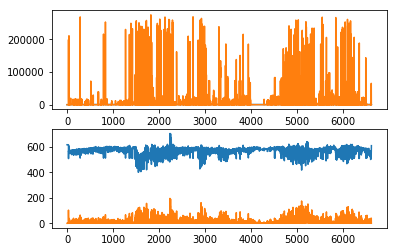

In [71]:
m[:,0,:].shape
joint_slice = m[:,0,:]
gradient_x = np.abs(np.diff(joint_slice[:,0]))
gradient_y = np.abs(np.diff(joint_slice[:,1]))
abs_grad = gradient_x * gradient_x + gradient_y + gradient_y
plt.subplot(2,1,1)
plt.plot(joint_slice[:,0])
plt.plot(abs_grad)
plt.subplot(2,1,2)
plt.plot(joint_slice[:,1])
plt.plot(gradient_y)

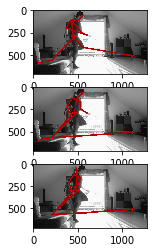

In [72]:
index = np.argmax(abs_grad)
plt.subplot(3,1,1)
plt.imshow(make_frame(times[index-1]))
plt.subplot(3,1,2)
plt.imshow(make_frame(times[index]))
plt.subplot(3,1,3)
plt.imshow(make_frame(times[index+1]))

In [70]:
maxv = np.max(abs_grad)
threshold = 0.5 * maxv
for i in range(1,abs_grad.shape[0]-1):
    if abs_grad[i] > threshold:
        print(f"index {i} i: {m[i,0]} i-1: {m[i-1,0]} i+1: {m[i+1,0]}")
        m[i,0] = (m[i-1,0] + m[i+1,0])/2
        print(f"after {m[i,0]}")

index 415 i: [ 1117.36211038   513.30783129] i-1: [ 613.63916445  572.07420941] i+1: [ 592.86121941  585.65461421]
after [ 603.25019193  578.86441181]
index 442 i: [ 1117.77322721   513.0420959 ] i-1: [ 618.47134614  561.28079081] i+1: [ 596.02623463  585.10165405]
after [ 607.24879038  573.19122243]
index 517 i: [ 576.8273387   584.80213976] i-1: [ 578.7560786   582.14999723] i+1: [ 1116.52136874   513.39527535]
after [ 847.63872367  547.77263629]
index 518 i: [ 1116.52136874   513.39527535] i-1: [ 847.63872367  547.77263629] i+1: [ 568.70287681  582.48982453]
after [ 708.17080024  565.13123041]
index 684 i: [ 530.04149008  565.59473324] i-1: [ 719.59264231  598.37808418] i+1: [ 1117.43499744   511.4459753 ]
after [ 918.51381987  554.91202974]
index 685 i: [ 1117.43499744   511.4459753 ] i-1: [ 918.51381987  554.91202974] i+1: [ 534.02960348  569.52572989]
after [ 726.27171168  562.21887982]
index 1017 i: [ 1117.82259512   513.9614172 ] i-1: [ 599.27959538  584.88239217] i+1: [ 595.24

after [ 826.01420735  534.44087887]
index 2954 i: [ 586.46655691  585.55593038] i-1: [ 574.97548366  580.08379544] i+1: [ 1116.61260504   510.27027321]
after [ 845.79404435  545.17703432]
index 2956 i: [ 1116.83286285   510.48549891] i-1: [ 1116.61260504   510.27027321] i+1: [ 554.65606284  555.26928997]
after [ 835.63433394  532.76978159]
index 2963 i: [ 533.43302941  530.25567341] i-1: [ 536.32135081  552.33130503] i+1: [ 1111.78791642   503.31941676]
after [ 824.05463362  527.82536089]
index 2964 i: [ 1111.78791642   503.31941676] i-1: [ 824.05463362  527.82536089] i+1: [ 579.14605898  602.29616344]
after [ 701.6003463   565.06076217]
index 2965 i: [ 579.14605898  602.29616344] i-1: [ 701.6003463   565.06076217] i+1: [ 1112.10975552   502.92969131]
after [ 906.85505091  533.99522674]
index 2988 i: [ 570.06797063  560.74530244] i-1: [ 671.02090454  565.43792558] i+1: [ 1111.66327381   503.33801723]
after [ 891.34208918  534.3879714 ]
index 3031 i: [ 511.77590799  586.41984868] i-1: [

index 4750 i: [  67.09162134  589.00510681] i-1: [  66.630633    588.88658452] i+1: [ 591.39667813  548.33696957]
after [ 329.01365557  568.61177704]
index 4751 i: [ 591.39667813  548.33696957] i-1: [ 329.01365557  568.61177704] i+1: [ 1115.70173493   507.66883233]
after [ 722.35769525  538.14030469]
index 4752 i: [ 1115.70173493   507.66883233] i-1: [ 722.35769525  538.14030469] i+1: [ 490.73690569  580.64746904]
after [ 606.54730047  559.39388687]
index 4754 i: [ 483.86180396  580.98203915] i-1: [ 490.73690569  580.64746904] i+1: [ 1115.79962321   507.56673855]
after [ 803.26826445  544.10710379]
index 4755 i: [ 1115.79962321   507.56673855] i-1: [ 803.26826445  544.10710379] i+1: [ 474.26256943  582.94323254]
after [ 638.76541694  563.52516817]
index 4766 i: [ 1114.72060335   506.98063385] i-1: [ 697.15919369  531.88737288] i+1: [ 589.45034474  546.82645422]
after [ 643.30476922  539.35691355]
index 4767 i: [ 589.45034474  546.82645422] i-1: [ 643.30476922  539.35691355] i+1: [  64.

index 6167 i: [ 1112.35039997   502.97045851] i-1: [ 605.57162267  555.84973526] i+1: [ 568.83581996  583.37881851]
after [ 587.20372131  569.61427689]
index 6244 i: [ 572.68233663  582.24383688] i-1: [ 616.77373648  563.83594114] i+1: [ 1117.83385921   511.1852417 ]
after [ 867.30379784  537.51059142]
index 6265 i: [ 595.55874595  591.64807749] i-1: [ 717.76144254  597.38804591] i+1: [ 1117.9812988    513.33934593]
after [ 917.87137067  555.36369592]
index 6266 i: [ 1117.9812988    513.33934593] i-1: [ 917.87137067  555.36369592] i+1: [ 581.84828234  587.97542263]
after [ 749.85982651  571.66955927]
index 6616 i: [ 684.57432109  520.33046579] i-1: [ 625.73890305  527.87495756] i+1: [ 114.29191077  609.5456841 ]
after [ 370.01540691  568.71032083]


In [57]:
def smooth(a,WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    v = np.ones(WSZ,dtype=int)
    out0 = np.convolve(a,v,'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

In [58]:
for i in range(m.shape[1]):
    for j in range(m.shape[2]):
        m[:,i,j] = smooth(m[:,i,j],5)

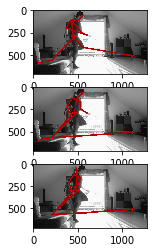

In [73]:
plt.subplot(3,1,1)
plt.imshow(make_frame(times[index-1]))
plt.subplot(3,1,2)
plt.imshow(make_frame(times[index]))
plt.subplot(3,1,3)
plt.imshow(make_frame(times[index+1]))